In [30]:
from modules import IO
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette("hls", 19)
%matplotlib inline

In [2]:
data_folder = './data/'
output_folder = './output/'
tmdb_genres_list = IO(data_folder + 'tmdb_genres_list.pkl').read_pickle()
movies = IO(data_folder + 'tmdb_processed.pkl').read_pickle()

In [3]:
movies = movies[130973:]

In [4]:
tmdb_all = movies
print(len(tmdb_all))
print(tmdb_all[10])

tmdb_all_genres_count = np.zeros(len(tmdb_genres_list), dtype=int)
tmdb_overview_len = []

for m in tmdb_all:
    for i in m['genre_ids']:
        tmdb_all_genres_count[i] += 1
    tmdb_overview_len.append(len(m['overview'].split(' ')))
    
tmdb_overview_len = np.array(tmdb_overview_len)

30000
{'vote_count': 9, 'id': 338520, 'video': False, 'vote_average': 4.2, 'title': 'Apparition', 'popularity': 2.35347, 'poster_path': '/tzEvQ9dn2jZRAA0a1uRyKHlQpAK.jpg', 'original_language': 'en', 'original_title': 'Apparition', 'genre_ids': [16, 10], 'backdrop_path': '/yvgCczUsoe3EMWp8OYS6L3jK3ts.jpg', 'adult': False, 'overview': "When his beautiful fiancée, Lori, is killed in a car accident, Doug retreats in solitude to the isolated farmhouse that should have been his new family's home. As he grieves and further isolates himself from his friends and society, he learns that he is not alone in this quaint home...", 'release_date': '2015-05-05'}


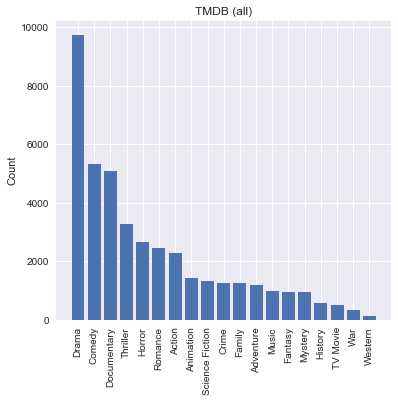

In [5]:
plt.figure(figsize=(6, 5.5))

plt.bar(range(len(tmdb_all_genres_count)), tmdb_all_genres_count[np.argsort(tmdb_all_genres_count)[::-1]]);
plt.xticks(range(len(tmdb_all_genres_count)), np.array(tmdb_genres_list)[np.argsort(tmdb_all_genres_count)[::-1]], \
           rotation=90);
plt.ylabel('Count');
plt.title('TMDB (all)');
plt.savefig(output_folder + 'eda02.png', bbox_inches='tight');

The number of movie overviews with no less than 20 words: 133664
The number of movie overviews with no less than 50 words: 90938
The number of movie overviews with no less than 100 words: 27353


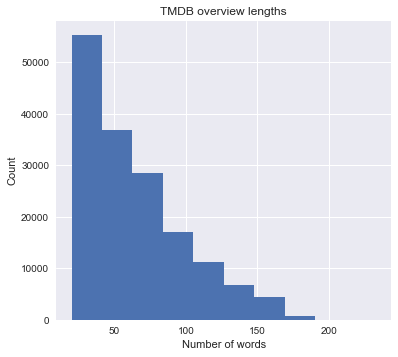

In [9]:
plt.figure(figsize=(6, 5.5))
plt.hist(tmdb_overview_len);
plt.xlabel('Number of words');
plt.ylabel('Count');
plt.title('TMDB overview lengths');
plt.savefig(output_folder + 'eda03.png', bbox_inches='tight');

print('The number of movie overviews with no less than 20 words: {}'.format(np.sum(tmdb_overview_len >= 30)))
print('The number of movie overviews with no less than 50 words: {}'.format(np.sum(tmdb_overview_len >= 50)))
print('The number of movie overviews with no less than 100 words: {}'.format(np.sum(tmdb_overview_len >= 100)))

## imbalanced classes merge?

In [14]:
Genre_ID_to_name={}
for i in range(len(tmdb_genres_list)):
    genre_id=i
    genre_name=tmdb_genres_list[i]
    Genre_ID_to_name[genre_id]=genre_name

In [15]:
# This function just generates all possible pairs of movies
def list2pairs(l):
    # itertools.combinations(l,2) makes all pairs of length 2 from list l.
    pairs = list(itertools.combinations(l, 2))
    # then the one item pairs, as duplicate pairs aren't accounted for by itertools
    for i in l:
        pairs.append([i,i])
    return pairs

In [16]:
allPairs = []
for movie in movies:
    allPairs.extend(list2pairs(movie['genre_ids']))

In [17]:
nr_ids = np.unique(allPairs)
visGrid = np.zeros((len(nr_ids), len(nr_ids)))
for p in allPairs:
    visGrid[np.argwhere(nr_ids==p[0]), np.argwhere(nr_ids==p[1])]+=1
    if p[1] != p[0]:
        visGrid[np.argwhere(nr_ids==p[1]), np.argwhere(nr_ids==p[0])]+=1

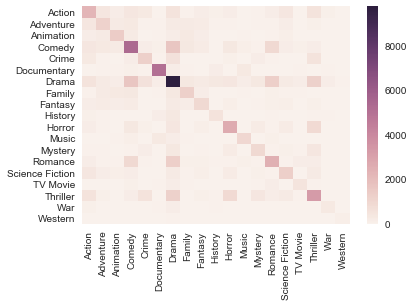

In [18]:
annot_lookup = []
for i in range(len(nr_ids)):
    annot_lookup.append(Genre_ID_to_name[nr_ids[i]])

sns.heatmap(visGrid, xticklabels=annot_lookup, yticklabels=annot_lookup)

The above image shows how often the genres occur together, as a heatmap

Important thing to notice in the above plot is the diagonal. The diagonal corresponds to self-pairs, i.e. number of times a genre, say Drama occurred with Drama. Which is basically just a count of the total times that genre occurred!

As we can see there are a lot of dramas in the data set, it is also a very unspecific label. There are nearly no documentaries or TV Movies. Horror is a very distinct label, and romance is also not too widely spread.

To account for this unbalanced data, there are multiple things we can try to explore what interesting relationships can be found.

In [19]:
from sklearn.cluster import SpectralCoclustering

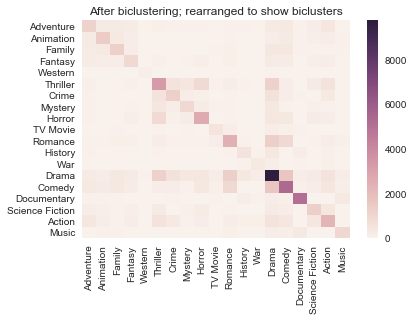

In [20]:
model = SpectralCoclustering(n_clusters=6)
model.fit(visGrid)

fit_data = visGrid[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

annot_lookup_sorted = []
for i in np.argsort(model.row_labels_):
    annot_lookup_sorted.append(Genre_ID_to_name[nr_ids[i]])
    
sns.heatmap(fit_data, xticklabels=annot_lookup_sorted, yticklabels=annot_lookup_sorted, annot=False)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

## text is useful!

In [21]:
description_crime = np.array([m['overview'] for m in tmdb_all if 4 in m['genre_ids']])

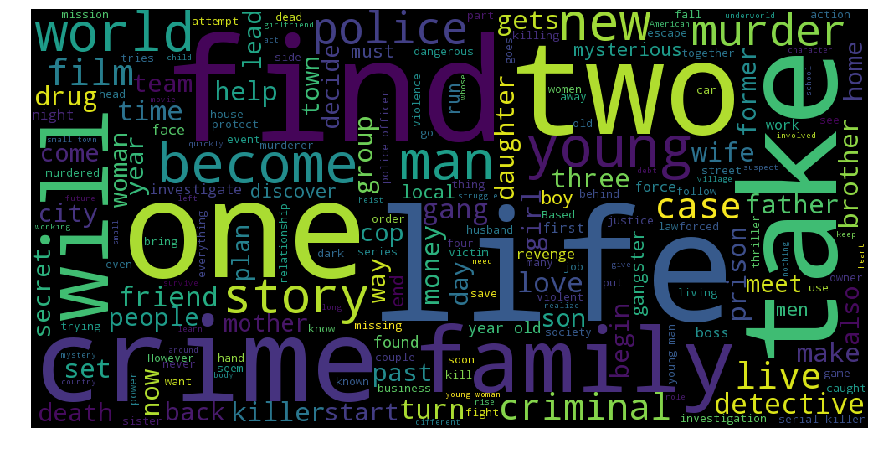

In [22]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 500).generate(''.join(description_crime));
plt.figure(figsize=(15,8));
plt.imshow(wordcloud);
plt.axis('off');

In [23]:
description_romance = np.array([m['overview'] for m in tmdb_all if 13 in m['genre_ids']])

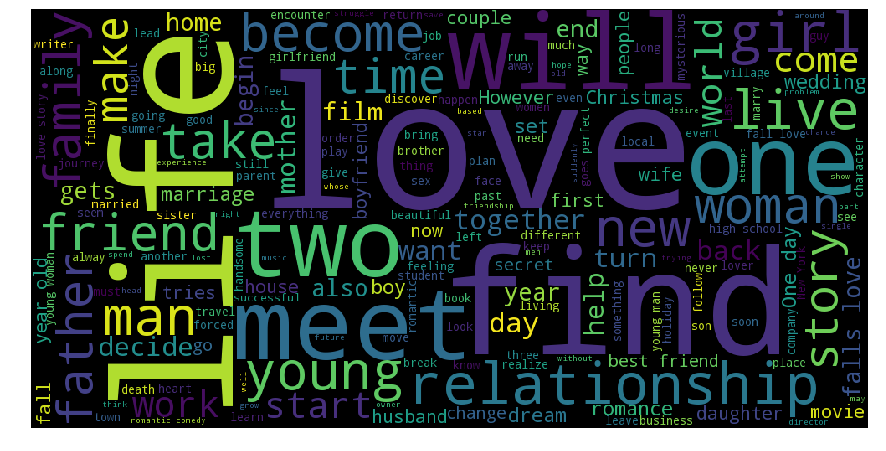

In [24]:
wordcloud = WordCloud(width = 1000, height = 500).generate(''.join(description_romance));
plt.figure(figsize=(15,8));
plt.imshow(wordcloud);
plt.axis('off');

In [48]:
movies[0]

{'adult': False,
 'backdrop_path': '/t3JzM9vDVoww1w8hITFwzn1gxpt.jpg',
 'genre_ids': [6],
 'id': 374517,
 'original_language': 'en',
 'original_title': 'The Merchant of Venice',
 'overview': "A short film directed by Orson Welles based on William Shakespeare's play of the same name. While actually completed, it is frequently cited as an unfinished film, though better described as a partially lost film due to the loss of film negatives. A restored and reconstructed version of the film, made by using the original script and composer's notes, premiered at the 72nd Venice International Film Festival alongside Othello as part of the pre-opening ceremonies.",
 'popularity': 1.055391,
 'poster_path': '/vrW5muZcrqwZ2wIsLFJiMDmP0ID.jpg',
 'release_date': '2015-09-01',
 'title': 'The Merchant of Venice',
 'video': False,
 'vote_average': 10,
 'vote_count': 1}

## popularity, vote_average, vote_count, release year

In [50]:
pop = np.zeros(19)
for i in range(19):
    pop[i] = np.array([m['popularity'] for m in tmdb_all if i in m['genre_ids']]).mean()

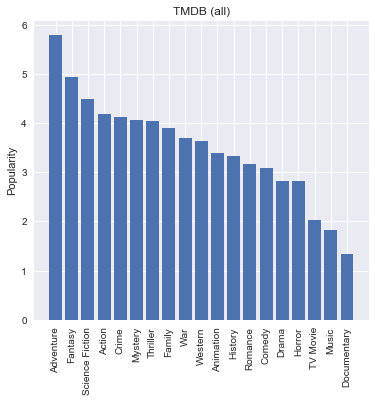

In [53]:
plt.figure(figsize=(6, 5.5))

plt.bar(range(len(pop)), pop[np.argsort(pop)[::-1]]);
plt.xticks(range(len(pop)), np.array(tmdb_genres_list)[np.argsort(pop)[::-1]], \
           rotation=90);
plt.ylabel('Popularity');
plt.title('TMDB (all)');
plt.savefig(output_folder + 'eda03.png', bbox_inches='tight');

In [67]:
vote = np.zeros(19)
for i in range(19):
    vote[i] = np.array([m['vote_average'] for m in tmdb_all if i in m['genre_ids']]).mean()

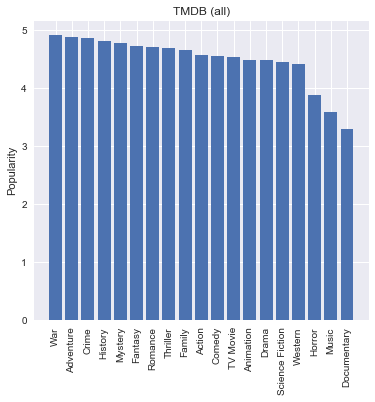

In [68]:
plt.figure(figsize=(6, 5.5))

plt.bar(range(len(vote)), vote[np.argsort(vote)[::-1]]);
plt.xticks(range(len(vote)), np.array(tmdb_genres_list)[np.argsort(vote)[::-1]], \
           rotation=90);
plt.ylabel('Popularity');
plt.title('TMDB (all)');
plt.savefig(output_folder + 'eda04.png', bbox_inches='tight');

In [69]:
vote_count = np.zeros(19)
for i in range(19):
    vote_count[i] = np.array([m['vote_count'] for m in tmdb_all if i in m['genre_ids']]).mean()

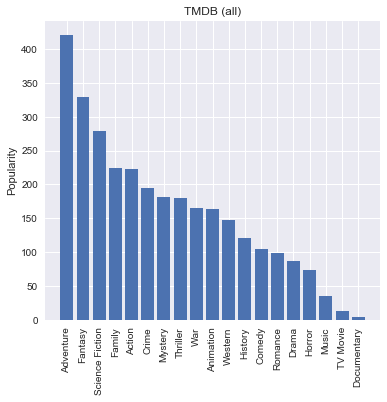

In [70]:
plt.figure(figsize=(6, 5.5))

plt.bar(range(len(vote)), vote_count[np.argsort(vote_count)[::-1]]);
plt.xticks(range(len(vote_count)), np.array(tmdb_genres_list)[np.argsort(vote_count)[::-1]], \
           rotation=90);
plt.ylabel('Popularity');
plt.title('TMDB (all)');
plt.savefig(output_folder + 'eda05.png', bbox_inches='tight');

In [4]:
year = np.zeros([47, 19])

for i in range(19):
    for m in movies:
        if i in m['genre_ids']:
            year[int(m['release_date'].split('-')[0]) - 1980, i] +=1

In [5]:
for t in range(42):
    year[t,:] /= year[t,:].sum()

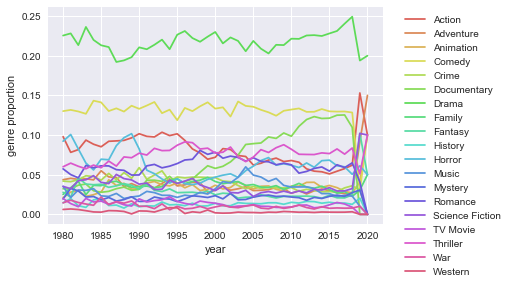

In [8]:
sns.set_palette("hls", 19)
for i in range(19):
    plt.plot(range(1980, 2021), year[:41,i], label = Genre_ID_to_name[i])

plt.xlabel('year')
plt.ylabel('genre proportion')
plt.legend(bbox_to_anchor=(1.04,1))

In [25]:
month = np.zeros([12, 19])

for i in range(19):
    for m in movies:
        if i in m['genre_ids']:
            month[int(m['release_date'].split('-')[1]) - 1, i] +=1

In [26]:
for t in range(12):
    month[t,:] /= month[t,:].sum()

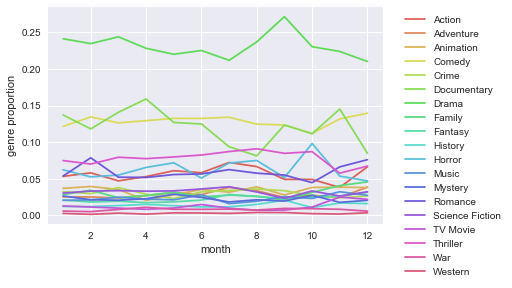

In [34]:
sns.set_palette("hls", 12)
for i in range(19):
    plt.plot(range(1,13), month[:,i], label = Genre_ID_to_name[i], color = color[i])

plt.xlabel('month')
plt.ylabel('genre proportion')
plt.legend(bbox_to_anchor=(1.04,1))